In [1]:
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
sys.path.append('mask_bracket')
import params

%matplotlib inline 

Using TensorFlow backend.


In [28]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1

def show_image(image, title=None):
    channels = image.shape[2] if len(image.shape) == 3 else 1
    if channels == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    oldfigsize = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (image.shape[1]//200+1,image.shape[0]//200+1)
    plt.autoscale(enable=True, axis='both', tight=False)
    plt.axis('off')
    plt.imshow(image, aspect='equal', interpolation='gaussian', cmap='gray' if channels == 1 else None)
    plt.show()
    plt.rcParams["figure.figsize"] = oldfigsize

Using our trained UNET model to highlight brackets. Wrapped it in highlight_brackets function

Train script is located at mask_bracket/train.py

In [100]:
def highlight_brackets(image):
  input_size = params.input_size
  model = params.model_factory()
  model.load_weights('mask_bracket/baseline.h5')
  img = params.simplify_image(image)

  orig_height, orig_width = img.shape
  img = cv2.resize(img, (input_size, input_size))
  img = np.array(img, np.float32) / 255
  preds = model.predict(img.reshape(1,input_size,input_size,1))
  preds = np.squeeze(preds, axis=3)
  pred = preds[0]
  pred = cv2.resize(pred, (orig_width, orig_height))
  res = (pred >= 0.5).astype(int)*255
  return res.astype("uint8")

In [115]:
path = "sample6small400.jpg"

In [116]:
original_image = cv2.imread(path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

Getting masks for brackets

In [ ]:
highlighted = highlight_brackets(image)
show_image(highlighted)

Then, it will be easy to find boundaries with cv2.findContours

In [107]:
def get_boundaries(imgray):
    _, contours, _  = cv2.findContours(imgray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for cords in contours:
         cords = np.squeeze(cords)
         if len(cords.shape)>1:
             x = [a[0] for a in cords]
             y = [a[1] for a in cords]
             minx, maxx = np.min(x), np.max(x)
             miny, maxy = np.min(y), np.max(y)
             boxes.append((minx,miny,maxx,maxy))
    return boxes        
            
def draw_boundaries(image, boxes):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    for (minx,miny,maxx,maxy) in boxes:
         rect = Rectangle((minx-1,miny-3),maxx-minx+1,maxy-miny+3,linewidth=1,edgecolor='g',facecolor='none')
         ax.add_patch(rect)

Let's see the result for this step

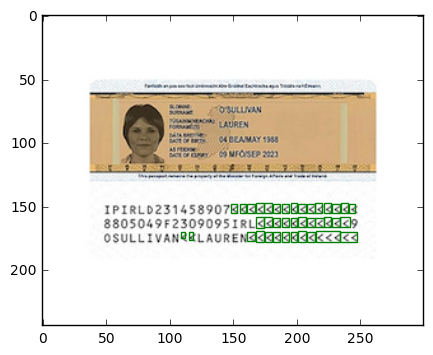

In [108]:
boxes = get_boundaries(highlighted)
draw_boundaries(original_image, boxes)

In [109]:
simplified_image = params.simplify_image(image)

Converting image to united lines

In [110]:
def get_lines(img):
    gradX = cv2.morphologyEx(simplified_image, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (20, 10)))
    return cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
lines = get_lines(simplified_image)    

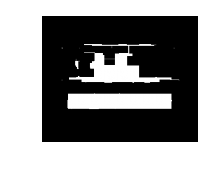

In [111]:
show_image(lines)

Knowing bracket positions we can get miny and maxy for each bracket row

In [112]:
same_row_dist = 5
bracket_min_y = np.unique([int(box[1]/same_row_dist) for box in boxes])*same_row_dist
bracket_max_y = np.unique([int(np.ceil(box[3]/same_row_dist)) for box in boxes])*same_row_dist
bracket_heights = list(zip(bracket_min_y, bracket_max_y))

For each bracket row we can find minX and maxX boundaries

In [113]:
brackets_lines = []
for i in range(len(bracket_heights)): 
    miny, maxy = bracket_heights[i]
    line = np.where(lines[miny:maxy,:] > 100)[1]
    brackets_lines.append( (np.min(line), miny, np.max(line),maxy) )

Showing the final result

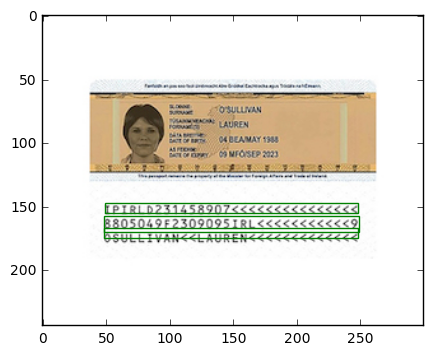

In [114]:
draw_boundaries(original_image, brackets_lines)